# InducibleGenes down in Rad21KO and the enhancers in the same TAD


SUBSETS:
- Gene subset = 723 genes inducible in WT (RNAseq WT 2hLPS vs WT UT) that are downreguated in the Rad21KO after 2h LPS
    - 341 associate to an inducible enhancer in the same TAD.
- Enhancer subset = 1112 intergenic otsuni enhancers upregulated by LPS (GROseq WT 1hLPS vs WT UT), 
    - 1087 of them are in the same TAD as an inducible gene.


In [1]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

using DataFrames,CSV,Seaborn,Statistics
using NoLongerProblems, PrettyPlotting, NoLongerProblems_Pandas
using PyCall, RCall
import Pandas 

include(ENV["Code"]*"/../Code_Paper/Databases/Cuartero2018.jl")
include(ENV["Code"]*"/../Code_Paper/Code/GenomicTracks.jl")
include(ENV["Code"]*"/../Code_Paper/Databases/ProcessedData_mm9.jl")
include("Functions.jl")

maketablesforanalysis (generic function with 1 method)

### Generate BED file wit WT otsuni intergenic inducible enhancers 

In [2]:
# Otsuni Enhancers
enhancers = Cuartero2018.otsuni_enhancers()
enhancers[!,:coordinates] = "chr".*string.(enhancers[!,:chr]) .* ":" .* string.(enhancers[!,:start]) .* "-" .* string.(enhancers[!,:end])
bed_writer_cols(enhancers, "../../Code_Paper/Databases/Cuartero2018/OtsuniEnhancers.bed", chr = :chr, start_ = :start, end_ = :end)

# GROseq Inducible Enhancers
gro_enh = Cuartero2018.get_DESEq_OTSUNIENH("WT1", "WT0")
# Intergenic
gro_enh = gro_enh[gro_enh[!,:Inter_Intragenic].== "Intergenic", :]
bed_writer_cols(gro_enh, "../../Code_Paper/Databases/Cuartero2018/Transcribed_OtsuniEnhancersWT.bed", chr = :chr, start_ = :start, end_ = :end);
# upregulated after LPS
gro_enh = gro_enh[gro_enh[!,:log2FoldChange_Enh].>0, :]
# DE after LPS
gro_enh = gro_enh[gro_enh[!,:padj_Enh].<0.05, :]
bed_writer_cols(gro_enh, "../../Code_Paper/Databases/Cuartero2018/IntergenicGROseqInducible_OtsuniEnhancersWT.bed", chr = :chr, start_ = :start, end_ = :end);
gro_enh_wtKO = Cuartero2018.get_DESEq_OTSUNIENH("FL1", "WT1")

test = innerjoin(gro_enh[:, [:coordinates]], gro_enh_wtKO, on = :coordinates); n = nrow(test)

testde = test[test[!,:padj_Enh].< 0.05, :]; nde = nrow(testde)
testdeup = testde[testde[!,:log2FoldChange_Enh].> 0, :] ; nup = nrow(testdeup)
testdown = testde[testde[!,:log2FoldChange_Enh].< 0, :] ; ndown = nrow(testdown)

bed_writer_cols(testde, "../../Code_Paper/Databases/Cuartero2018/IntergenicGROseqInducible_OtsuniEnhancers_DE_Rad21KO1HLPS.bed", chr = :chr, start_ = :start, end_ = :end)
bed_writer_cols(testdown, "../../Code_Paper/Databases/Cuartero2018/IntergenicGROseqInducible_OtsuniEnhancers_down_Rad21KO1HLPS.bed", chr = :chr, start_ = :start, end_ = :end)
bed_writer_cols(testdeup, "../../Code_Paper/Databases/Cuartero2018/IntergenicGROseqInducible_OtsuniEnhancers_up_Rad21KO1HLPS.bed", chr = :chr, start_ = :start, end_ = :end)

println("""
    enhancers considered (Rad21KO 1hLPS vs WT): $n
\t    n DE = $nde
\t    n up = $nup
\t    n down = $ndown
    """)

    enhancers considered (Rad21KO 1hLPS vs WT): 1112
	    n DE = 67
	    n up = 3
	    n down = 64
    


### Generate Gene Sets

In [3]:
rnawtko = Cuartero2018.Cuartero2018Deseq(sample1 = "FL2",sample2 = "WT2")
rnawtko = rnawtko[(rnawtko[!,:log2FoldChange].<0).*(rnawtko[!,:padj].<0.05), :]
rnawt = Cuartero2018.Cuartero2018Deseq(sample1 = "WT2",sample2 = "WTUT")
rnawt = rnawt[(rnawt[!,:log2FoldChange].>0).*(rnawt[!,:padj].<0.05), :]
geneset = intersect(rnawt[:, :GeneSymbol], rnawtko[:, :GeneSymbol])

# Generate RNAseq tables
rnawt = Cuartero2018.Cuartero2018Deseq(sample1 = "WT2",sample2 = "WTUT")
    rename!(rnawt, :log2FoldChange => :log2FoldChange_Gene)
    rename!(rnawt, :padj => :padj_Gene)

rnako = Cuartero2018.Cuartero2018Deseq(sample1 = "FL2",sample2 = "FLUT")
    rename!(rnako, :log2FoldChange => :log2FoldChange_Gene)
    rename!(rnako, :padj => :padj_Gene)

# Generate enhancer tables, make sure we are considering the same enhancers
gro_enhWT = gro_enh
gro_enhRad21KO = Cuartero2018.get_DESEq_OTSUNIENH("FL1", "FL0")
gro_enhRad21KO = innerjoin(gro_enhRad21KO, gro_enhWT[!,[:coordinates]], on = :coordinates);


### Make tables for figures

In [4]:
gro_gene = rnawt
gro_enh = gro_enhWT
filename = "GeneRNAseqEnhGROseqlog2FC_WT_CONTACTS.csv"
genotype = "WT"

tbwt = maketablesforanalysis(gro_gene, gro_enh, filename, genotype, contacts = true)


gro_gene = rnako
gro_enh = gro_enhRad21KO
filename = "GeneRNAseqEnhGROseqlog2FC_Rad21KO_CONTACTS.csv"
genotype = "Rad21KO"

tbko = maketablesforanalysis(gro_gene, gro_enh, filename, genotype, contacts = true);

### Analysis using the mean Enhlog2FoldChange per gene 

In [5]:
tb = tbwt
f = mean
genes = unique(tb[!,:GeneSymbol])
FC_gene = [f(tb[tb[!,:GeneSymbol].==ii, :Genelog2FoldChange]) for ii in genes]
FC_enh = [f(tb[tb[!,:GeneSymbol].==ii, :Enhlog2FoldChange]) for ii in genes]

x = FC_gene
y = FC_enh

using RCall
println("WT correlation test (mean Enhlog2FoldChange per gene)")
println(R"""
cor.test($x, $y,)
""")

wttb = DataFrames.DataFrame(
    GeneSymbol = genes,
    Genelog2FoldChange = FC_gene,
    Enhlog2FoldChange = FC_enh,
    Genotype = ["WT" for ii in FC_enh],
);

tb = tbko
genes = unique(tb[!,:GeneSymbol])
FC_gene = [f(tb[tb[!,:GeneSymbol].==ii, :Genelog2FoldChange]) for ii in genes]
FC_enh = [f(tb[tb[!,:GeneSymbol].==ii, :Enhlog2FoldChange]) for ii in genes]

x = FC_gene
y = FC_enh

println("Rad21KO correlation test (mean Enhlog2FoldChange per gene)")
println(R"""
cor.test($x, $y,)
""")

kotb = DataFrames.DataFrame(
    GeneSymbol = genes,
    Genelog2FoldChange = FC_gene,
    Enhlog2FoldChange = FC_enh,
    Genotype = ["Rad21KO" for ii in FC_enh],
);

print(size(kotb))



WT correlation test (mean Enhlog2FoldChange per gene)
RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 4.1481, df = 146, p-value = 5.666e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1723868 0.4618480
sample estimates:
      cor 
0.3246996 


Rad21KO correlation test (mean Enhlog2FoldChange per gene)
RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 1.662, df = 146, p-value = 0.09866
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02564518  0.29120416
sample estimates:
      cor 
0.1362625 


(148, 4)

In [6]:
t = vcat(wttb, kotb)
CSV.write("../SourceData/Fig6e_contacts.csv")
println("2-way ANOVA (Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol)")
println(R"""
t = $t
aov.s = lm(Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol, data = t)
summary(aov(aov.s))
""")

2-way ANOVA (Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol)
RObject{VecSxp}
                            Df Sum Sq Mean Sq F value   Pr(>F)    
Enhlog2FoldChange            1   49.6   49.57  63.629 4.13e-13 ***
Genotype                     1   69.5   69.50  89.214  < 2e-16 ***
GeneSymbol                 147  814.4    5.54   7.111  < 2e-16 ***
Enhlog2FoldChange:Genotype   1   15.2   15.16  19.455 1.99e-05 ***
Residuals                  145  113.0    0.78                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



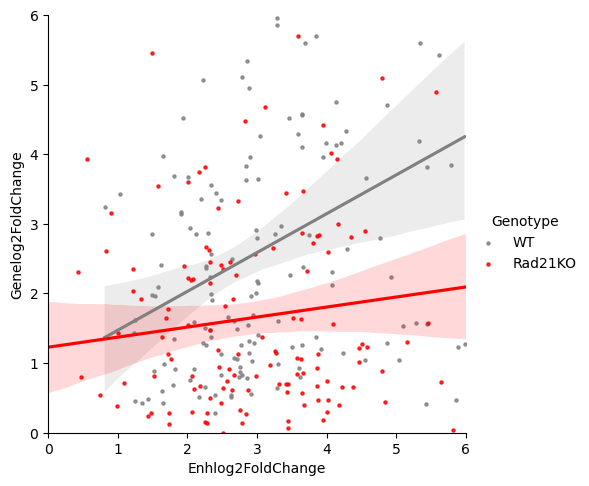

In [7]:
import Pandas
using NoLongerProblems_Pandas

pd = Pandas.DataFrame(t)
Seaborn.lmplot(data = pd, x = "Enhlog2FoldChange", y = "Genelog2FoldChange", hue = "Genotype", palette = ["gray", "red"], 
    scatter_kws = Dict("s"=>5))
ylim(0, 6)
xlim(0, 6)
squareplot()
savefigwithtext("GeneFCvsEnhFC_GenevsMeanCONTACTSEnh.svg")

### Analysis using all Enhlog2FoldChange per gene 
(unique gene-enh pairs, but their values duplicate if there are several genes or several enhancers in a TAD)

In [8]:
tb = tbwt
tb = tb[.!isnan.(tb[!,:Genelog2FoldChange]), :]
x = tb[!,:Genelog2FoldChange]
y = tb[!,:Enhlog2FoldChange]

using RCall

println("WT correlation test with duplicated values but unique pairs")
println(R"""
cor.test($x, $y,)
""")

tb = tbko
tb = tb[.!isnan.(tb[!,:Genelog2FoldChange]), :]
x = tb[!,:Genelog2FoldChange]
y = tb[!,:Enhlog2FoldChange]

using RCall

println("Rad21KO correlation test with duplicated values but unique pairs")
println(R"""
cor.test($x, $y,)
""")

WT correlation test with duplicated values but unique pairs
RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 6.5521, df = 406, p-value = 1.722e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2187188 0.3944786
sample estimates:
     cor 
0.309237 


Rad21KO correlation test with duplicated values but unique pairs
RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 3.8353, df = 406, p-value = 0.0001454
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09156097 0.27900331
sample estimates:
      cor 
0.1869835 




In [9]:
t = vcat(tbwt, tbko, )

println("2-way ANOVA (Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol)")
println(R"""
t = $t
aov.s = lm(Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol, data = t)
summary(aov(aov.s))
""")

2-way ANOVA (Genelog2FoldChange~Enhlog2FoldChange*Genotype+GeneSymbol)
RObject{VecSxp}
                            Df Sum Sq Mean Sq F value   Pr(>F)    
Enhlog2FoldChange            1  141.1  141.07  235.91  < 2e-16 ***
Genotype                     1  218.0  217.97  364.51  < 2e-16 ***
GeneSymbol                 147 2254.6   15.34   25.65  < 2e-16 ***
Enhlog2FoldChange:Genotype   1   26.6   26.61   44.50 5.36e-11 ***
Residuals                  665  397.7    0.60                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



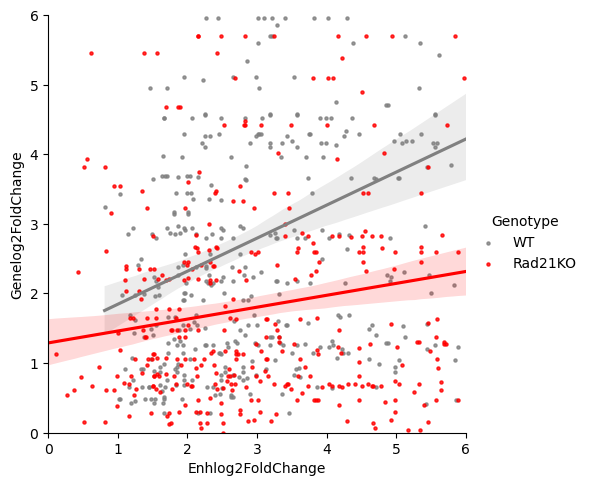

In [10]:
import Pandas
using NoLongerProblems_Pandas


pd = Pandas.DataFrame(t)
Seaborn.lmplot(data = pd, x = "Enhlog2FoldChange", y = "Genelog2FoldChange", hue = "Genotype", palette = ["gray", "red"], 
    scatter_kws = Dict("s"=>5))
ylim(0, 6)
xlim(0, 6)
squareplot()

In [11]:
import Pkg; Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [7e6ae17a] BioSequences v2.0.5
  [336ed68f] CSV v0.9.11
  [8f4d0f93] Conda v1.5.2
  [a93c6f00] DataFrames v1.2.2
  [31c24e10] Distributions v0.25.28
  [c2308a5c] FASTX v1.2.0
  [09f84164] HypothesisTests v0.10.6
  [7073ff75] IJulia v1.23.2
  [916415d5] Images v0.24.1
  [96684042] InformationMeasures v0.3.1
  [10e44e05] MATLAB v0.8.2
  [f8716d33] MultipleTesting v0.5.0
  [92933f4c] ProgressMeter v1.7.1
  [438e738f] PyCall v1.92.5
  [d330b81b] PyPlot v2.10.0
  [6f49c342] RCall v0.13.12
  [d2ef9438] Seaborn v1.0.0
  [2913bbd2] StatsBase v0.33.13
